# Goal

* Initial assessment of how accuracy of DESeq2 changes with the BD window used to select 'heavy' fraction samples
* Just testing on 'validation' run which just has 100% incorporators

# User variables

In [9]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [142]:
import glob
from os.path import abspath
import nestly
import itertools

In [11]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

# Using nestly: different BD ranges

In [160]:
# building tree structure
nest = nestly.Nest()

## params that vary
BD_min = np.arange(1.67, 1.77, 0.02).tolist()
BD_max = [x + 0.04 for x in BD_min]
f = lambda x: {'BD_range': str(x[0]) + '-' + str(x[1]), 
               'BD_min':x[0], 
               'BD_max':x[1]}
BD_range = [f(x) for x in itertools.product(BD_min, BD_max) 
            if x[0] < x[1]]
nest.add('BD_range', BD_range, update=True)


## set params
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
### phyloseq & BD-shift files
nest.add('inFileDir', [os.path.join(workDir, 'validation')], create_dir=False)
nest.add('phyloseq', ['OTU_n2_abs1e10_sub20000'], create_dir=False)
nest.add('BD_shift', ['ampFrags_kde_dif_incorp_BD-shift.txt'], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
buildDir = os.path.join(workDir, 'DESeq_BD-range')
nest.build(buildDir)

In [161]:
bashFile = os.path.join(workDir, 'SIPSimRun.sh')

In [162]:
%%writefile $bashFile
#!/bin/bash
  
# copy input files to prevent parallel file reading errors
cp {inFileDir}/{phyloseq}.physeq {phyloseq}.physeq
cp {inFileDir}/{BD_shift} {BD_shift}
    
#-- R analysis --#
export PATH={R_dir}:$PATH

## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    {phyloseq}.physeq \
    --BD_min {BD_min} \
    --BD_max {BD_max} \
    > {phyloseq}_filt.physeq
## making ordination
phyloseq_ordination.r \
    {phyloseq}_filt.physeq \
    {phyloseq}_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    {phyloseq}_filt.physeq \
    --log2 {log2} \
    --hypo greater \
    > {phyloseq}_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {BD_shift} \
    {phyloseq}_DESeq2 \
    --padj {padj}    

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/SIPSimRun.sh


In [163]:
!chmod 775 $bashFile

In [164]:
!cd $workDir; \
    nestrun -j 30 --template-file $bashFile -d DESeq_BD-range --log-file log.txt

2015-07-08 20:22:09,555 * INFO * Template: ./SIPSimRun.sh
2015-07-08 20:22:09,557 * INFO * [235570] Started ./SIPSimRun.sh in DESeq_BD-range/1.67-1.79
2015-07-08 20:22:09,559 * INFO * [235571] Started ./SIPSimRun.sh in DESeq_BD-range/1.73-1.77
2015-07-08 20:22:09,561 * INFO * [235574] Started ./SIPSimRun.sh in DESeq_BD-range/1.69-1.77
2015-07-08 20:22:09,564 * INFO * [235578] Started ./SIPSimRun.sh in DESeq_BD-range/1.71-1.75
2015-07-08 20:22:09,567 * INFO * [235583] Started ./SIPSimRun.sh in DESeq_BD-range/1.75-1.81
2015-07-08 20:22:09,571 * INFO * [235591] Started ./SIPSimRun.sh in DESeq_BD-range/1.71-1.73
2015-07-08 20:22:09,574 * INFO * [235598] Started ./SIPSimRun.sh in DESeq_BD-range/1.73-1.79
2015-07-08 20:22:09,578 * INFO * [235611] Started ./SIPSimRun.sh in DESeq_BD-range/1.69-1.71
2015-07-08 20:22:09,582 * INFO * [235625] Started ./SIPSimRun.sh in DESeq_BD-range/1.77-1.81
2015-07-08 20:22:09,585 * INFO * [235635] Started ./SIPSimRun.sh in DESeq_BD-range/1.69-1.73
2015-07-08 2

In [165]:
# aggregating confusion matrix data
## table
!cd $workDir; \
    nestagg delim \
        -d DESeq_BD-range \
        -k BD_min,BD_max \
        -o ./DESeq_BD-range/DESeq2-cMtx_table.csv \
        DESeq2-cMtx_table.csv

## overall
!cd $workDir; \
    nestagg delim \
        -d DESeq_BD-range \
        -k BD_min,BD_max\
        -o ./DESeq_BD-range/DESeq2-cMtx_overall.csv \
        DESeq2-cMtx_overall.csv
    
## byClass
!cd $workDir; \
    nestagg delim \
        -d DESeq_BD-range \
        -k BD_min,BD_max \
        -o ./DESeq_BD-range/DESeq2-cMtx_byClass.csv \
        DESeq2-cMtx_byClass.csv

### Plotting results

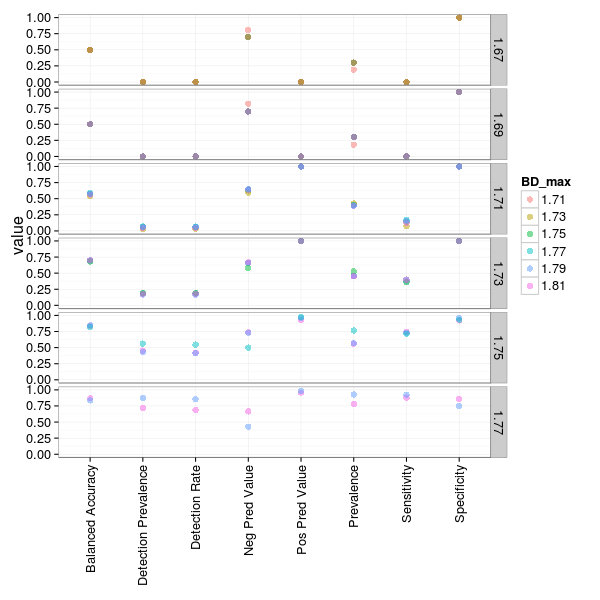

In [166]:
%%R -i workDir -w 600 -h 600
setwd(workDir)

byClass = read.csv('./DESeq_BD-range/DESeq2-cMtx_byClass.csv')

byClass$byClass[is.na(byClass$byClass)] = 0

cat.str = function(x,y, col=':'){
    x = as.character(x)
    y = as.character(y)
    z = paste(c(x,y),collapse=col)
    return(z)
    }

byClass = byClass %>% 
    mutate(BD_range = mapply(cat.str, BD_min, BD_max)) %>%
    mutate(BD_min = as.character(BD_min),
           BD_max = as.character(BD_max)) 

p = ggplot(byClass, aes(X, byClass, color=BD_max)) +
    geom_point(alpha=0.5, size=3) +
    labs(y='value') +
    facet_grid(BD_min ~ .) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )
p

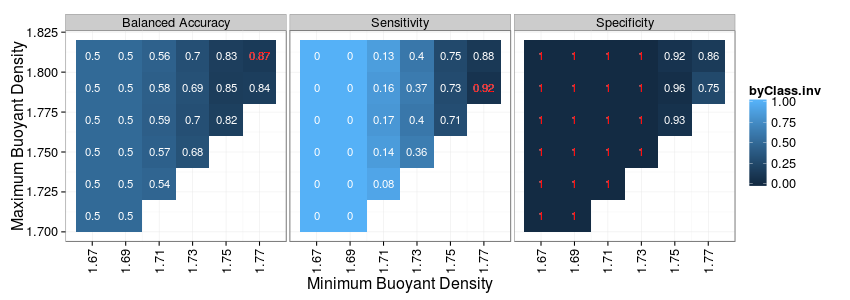

In [180]:
%%R -w 850 -h 300

col2keep = c('Balanced Accuracy', 'Sensitivity','Specificity')
byClass.f = byClass %>%
    filter(X %in% col2keep) %>%
    mutate(BD_min = as.numeric(BD_min),
           BD_max = as.numeric(BD_max),
           byClass = as.numeric(byClass),
           byClass.inv = 1 - byClass) 

byClass.fs = byClass.f %>%
    group_by(X) %>%
    summarize(byClass.max = max(byClass))

just.true = function(x){
    if(x == TRUE){
        return(1)
        } else{
        return(NA)
        }
    }

byClass.j = inner_join(byClass.f, byClass.fs, c('X' = 'X')) %>%
    mutate(max_val = as.numeric(byClass == byClass.max),
           byClass.txt = round(byClass, 2))
byClass.jf = byClass.j %>%
    filter(max_val == 1)

x.breaks = unique(byClass.j$BD_min)

p = ggplot(byClass.j, aes(BD_min, BD_max, fill=byClass.inv)) +
    geom_tile() +
    geom_text(aes(label=byClass.txt), color=c('white'), size=4) +
    geom_text(data=byClass.jf, aes(label=byClass.txt), color=c('red'), size=4) +
    scale_x_continuous(breaks=x.breaks) +
    labs(x='Minimum Buoyant Density', y='Maximum Buoyant Density') +
    facet_grid(. ~ X) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)
        )
p

***

# SANDBOX

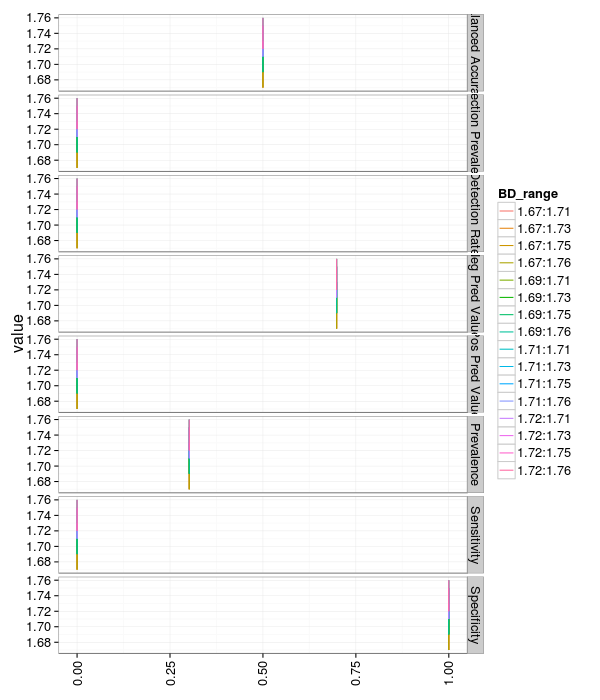

In [64]:
%%R -i workDir -w 600 -h 700
setwd(workDir)

byClass = read.csv('./DESeq_BD-range/DESeq2-cMtx_byClass.csv')

byClass$byClass[is.na(byClass$byClass)] = 0


#byClass$percIncorp = factor(byClass$percIncorp, levels=as.character(unique(sort(byClass$percIncorp))))
cat.str = function(x,y, col=':'){
    x = as.character(x)
    y = as.character(y)
    z = paste(c(x,y),collapse=col)
    return(z)
    }

byClass = byClass %>% 
    mutate(BD_range = mapply(cat.str, BD_min, BD_max))

p = ggplot(byClass, aes(byClass, ymin=BD_min, ymax=BD_max, color=BD_range)) +
    geom_linerange() +
    labs(y='value') +
    facet_grid(X ~ .) +
    #coord_flip() +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )
p

In [ ]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

## symlinking OTU subsample phyloseq file
# done by NESTLY?
# files: FILE.physeq, ampFrags_kde_dif_incorp_BD-shift.txt

## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    {otu_table}.physeq \
    --BD_min {BD_min} --BD_max {BD_max} \
    > {otu_table}_filt.physeq
    

# Chuck's method
## DESeq2
phyloseq_DESeq2.r \
    {otu_table}_filt.physeq \
    --log2 0.25 \
    > {otu_table}_filt_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_incorp_BD-shift.txt \
    {otu_table}_filt_DESeq2 \
    --padjBH 0.1
    
    
    
    
# altHypothesis = 'greater'
## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e10_sub20000_filt.physeq \
    --log2 0.25 \
    --hypo greater \
    > OTU_n2_abs1e10_sub20000_DESeq2
    
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs1e10_sub20000_DESeq2 \
    --padj 0.1    

In [ ]:
%%writefile $bashFile
#!/bin/bash
  
#-- R analysis --#
export PATH={R_dir}:$PATH

    # plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}_sub{subsample}.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}_sub{subsample} 
# running DeSeq2 and making confusion matrix on predicting incorporators
## making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs{abs}_sub{subsample}_w.txt \
    -s OTU_n2_abs{abs}_sub{subsample}_meta.txt \
    > OTU_n2_abs{abs}_sub{subsample}.physeq
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs{abs}_sub{subsample}.physeq \
    --BD_min {BD_min} --BD_max {BD_max} \
    > OTU_n2_abs{abs}_sub{subsample}_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs{abs}_sub{subsample}_filt.physeq \
    OTU_n2_abs{abs}_sub{subsample}_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs{abs}_sub{subsample}_filt.physeq \
    > OTU_n2_abs{abs}_sub{subsample}_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {fileName}_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub{subsample}_DESeq2 \
    --padj {padj} --log2 {log2} 